## Parameters

In [1]:
import os

ROOT_DIR= os.path.abspath("../Mask_RCNN/")
MODEL_PATH = os.path.abspath("F:/downloads_trash/models/square/mask_rcnn_bubbles_0014.h5")
#MODEL_PATH = os.path.abspath("F:/downloads_trash/models/pad64-2/mask_rcnn_bubbles_0013.h5")
#MODEL_PATH = os.path.abspath("F:/downloads_trash/mask_rcnn_bubbles_0010.h5")
DATASET_DIR= os.path.abspath("../MangaBubbles/")

print("Root:", ROOT_DIR)
print("Model:", MODEL_PATH)
print("Dataset:", DATASET_DIR)

MIN_BLOB_SIZE= 8000
MIN_BLOB_OVERLAP= 1000

Root: C:\Programming\Bubbles\Mask_RCNN
Model: F:\downloads_trash\models\square\mask_rcnn_bubbles_0014.h5
Dataset: C:\Programming\Bubbles\MangaBubbles


## Imports

In [2]:
import sys
import cv2
import numpy as np
import skimage
import copy
import random
import glob
import scipy
import PIL
import png

sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils, visualize

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow


import matplotlib.pyplot as plt

c:\programming\bubbles\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\programming\bubbles\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\programming\bubbles\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\programming\bubbles\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWa

## Helper Functions

In [3]:
def get_ax(rows=1, cols=1, size=10):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


def flatten(arrs):
	# Flatten blobs into single matrix for viewing
	x = np.zeros((arrs.shape[0], arrs.shape[1]), dtype=np.int16)
	for i in range(arrs.shape[2]):
		x[:,:]+= arrs[:,:,i]
	return x

def flattenList(lst):
	arr= np.array([x for x in lst])
	return flatten(arr)

def depad(original_image, padding):
     return original_image[(None if padding[0][0]==0 else padding[0][0]):(None if padding[0][1]==0 else -padding[0][1]),
                    (None if padding[1][0]==0 else padding[1][0]):(None if padding[1][1]==0 else -padding[1][1]), ...]

# ==============================================================================

## Load Model and Image

In [4]:
class InferenceConfig(Config):
    BACKBONE= 'resnet50'
    
    IMAGE_RESIZE_MODE='pad64'
    IMAGE_MIN_DIM=64
    IMAGE_MAX_DIM=64
    
    #TRAIN_ROIS_PER_IMAGE = 30
    
    #Blech
    NAME = "bubbles"
    NUM_CLASSES = 1 + 1  # background + 3 shapes
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    IMAGE_CHANNEL_COUNT= 1
    MEAN_PIXEL= np.array([123.7])

inference_config = InferenceConfig()
inference_config.display()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir= ROOT_DIR)
model.load_weights(MODEL_PATH, by_name=True)


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            1
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [64 64  1]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                    

--- 0.22304964065551758 seconds ---


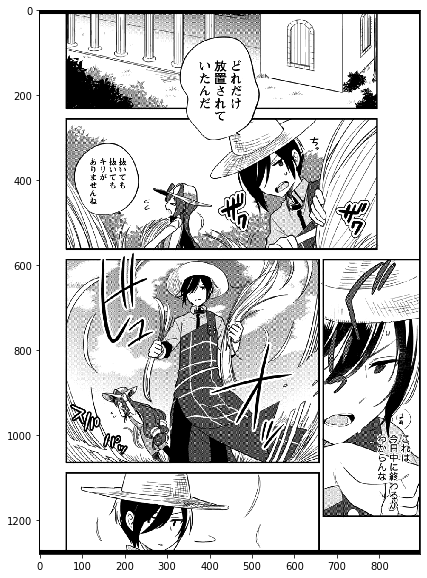

In [31]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import time
start_time = time.time()

imPath= "C:/Programming/Bubbles/MangaBubbles/train_original/images/scribbles/9/0023.jpg"
imPath= random.choice(glob.glob("C:/Programming/Bubbles/MangaBubbles/train_original/images/scribbles/9/*"))

original_image= skimage.io.imread(imPath, as_gray=True)
if np.max(original_image) <= 1:
    original_image= original_image*255
if len(original_image.shape) == 2:
    original_image= original_image[..., np.newaxis]

original_image, window, scale, padding, crop = utils.resize_image(original_image, min_dim=inference_config.IMAGE_MIN_DIM, max_dim=inference_config.IMAGE_MAX_DIM, min_scale=inference_config.IMAGE_MIN_SCALE, mode=inference_config.IMAGE_RESIZE_MODE)
disp_image= np.concatenate((original_image, original_image, original_image),axis=2)


get_ax().imshow(disp_image.astype(np.uint8))

PIL.Image.fromarray(np.uint8(disp_image)).save(f"C:/Users/Pray/Pictures/0original.png")

print("--- %s seconds ---" % (time.time() - start_time))

## Generate Masks

In [32]:
start_time = time.time()

results = model.detect([original_image], verbose=1)

print("--- %s seconds ---" % (time.time() - start_time))

Processing 1 images
image                    shape: (1280, 896, 1)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 896, 1)     min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  int32
anchors                  shape: (1, 286440, 4)        min:   -0.40451  max:    1.33300  float32
--- 0.42809534072875977 seconds ---


## Filter Low Confidence Masks

[0.99930453 0.9992976  0.95892686 0.7391345 ]
--- 0.4080817699432373 seconds ---


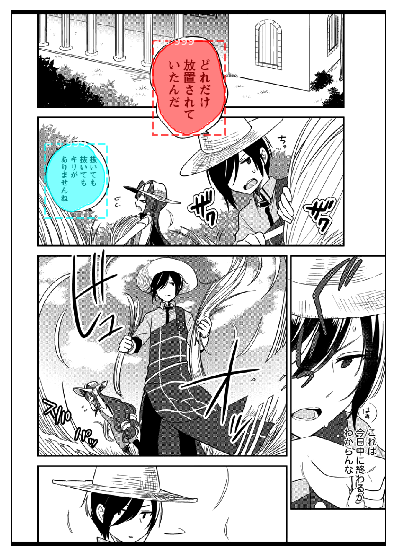

In [33]:
start_time = time.time()

r = copy.deepcopy(results[0])
print(r['scores'])

inds= []
for i in reversed(range(len(r['scores']))):
    if r['scores'][i] > .97:
        break
    else:
        inds.append(i)

r['masks']= np.delete(r['masks'], inds, 2)
r['scores']= np.delete(r['scores'], inds, 0)
r['class_ids']= np.delete(r['class_ids'], inds, 0)
r['rois']= np.delete(r['rois'], inds, 0)

im= visualize.display_instances(disp_image, r['rois'], r['masks'], r['class_ids'], 
                            ['a']*123, r['scores'], ax=get_ax())

PIL.Image.fromarray(im).save("C:/Users/Pray/Pictures/1masked.png")

print("--- %s seconds ---" % (time.time() - start_time))

## Thesholding and Denoising

--- 0.39308786392211914 seconds ---
Selected blobs:
1: [383 630] - 224883
26: [206  79] - 14223
42: [621  93] - 24312
434: [423 182] - 29145
528: [231 161] - 11949
575: [636 197] - 13046
712: [305 372] - 52986
720: [711 408] - 9264
775: [158 399] - 16622
1819: [560 676] - 8671
1823: [821 670] - 12404
2851: [552 909] - 16681
3294: [ 780 1012] - 50566
5003: [ 127 1185] - 20175
5006: [ 506 1182] - 51492
--- 0.6061351299285889 seconds ---


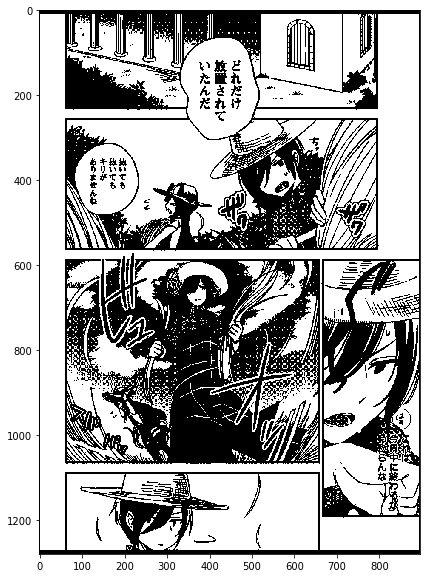

In [34]:
start_time = time.time()

# Convert image to pure black and white
__, greyImage= cv2.threshold(original_image, 240, 1, cv2.THRESH_BINARY)
greyImage= (greyImage*255).astype(np.uint8)

# Identify connected white blobs
blobStats= cv2.connectedComponentsWithStats(greyImage, 8, cv2.CV_16U)

# Identify larger blobs
blobLabels= [x for x in range(len(blobStats[2])) if blobStats[2][x][4] > MIN_BLOB_SIZE and x > 0]

# Move larger blobs to separate array
blobs= np.zeros([original_image.shape[0], original_image.shape[1], len(blobLabels)])
out= blobStats[1][...,np.newaxis] # Labeled (flat) image

for i,label in enumerate(blobLabels[0:]):
    blobs[:,:,i]= (out==label)[:,:,0]
blobs=blobs*255
print("--- %s seconds ---" % (time.time() - start_time))    

debug_list= [str(x) + ": " + str(blobStats[3][x].astype(np.uint16)) + " - " + str(blobStats[2][x][4]) for x in blobLabels]
print(f"Selected blobs:\n{chr(10).join(debug_list)}")
get_ax().imshow(greyImage.astype(np.uint8), cmap='Greys_r')

PIL.Image.fromarray(np.uint8(greyImage)).save(f"C:/Users/Pray/Pictures/2threshold.png")

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.14803314208984375 seconds ---


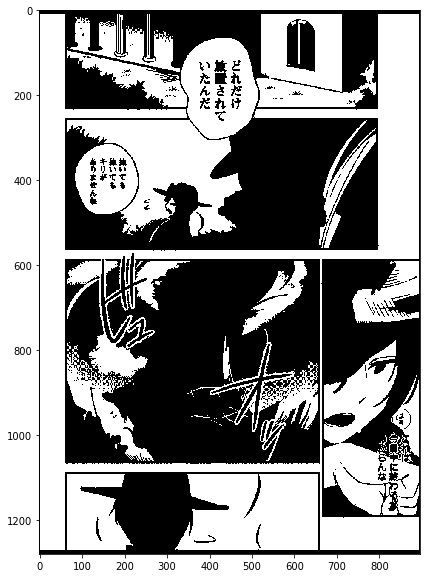

In [35]:
start_time = time.time()

# Display blobs post-size-filter for debug
arr= flatten(blobs.astype(np.uint8))
disp_arr= np.dstack((arr, arr, arr))
get_ax().imshow(disp_arr, cmap='Greys_r')

png.from_array(np.uint8(arr), mode="L").save(f"C:/Users/Pray/Pictures/3thresholdbig.png")

print("--- %s seconds ---" % (time.time() - start_time))

## Identify Overlapping Components

Selected blobs:
434: [423.87332304 182.52962772] - 29145
775: [158.05841656 399.74329202] - 16622
--- 0.12502789497375488 seconds ---


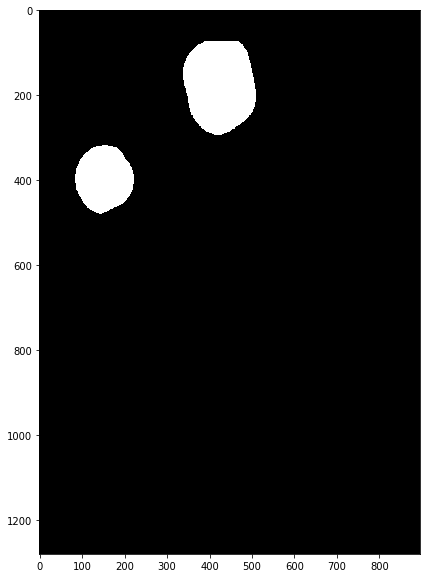

In [36]:
start_time = time.time()

# Loop through the list of (large) blobs
filteredBlobLabels= set([])
for msk in range(r['masks'].shape[2]):
    mask= r['masks'][:,:,msk]
    
    # Select blobs whose centroid falls within the mask and whose overlap with that mask is sufficient
    for i in range(len(blobLabels)):
        center= blobStats[3][blobLabels[i]]
        center= center.astype(np.uint16)
        
        overlap= np.count_nonzero(np.logical_and(mask, blobStats[1][:,:] == blobLabels[i]))
        if mask[center[1]][center[0]] and overlap > MIN_BLOB_OVERLAP:
            #print(f"Adding blob {blobLabels[i]} with center {center}")
            filteredBlobLabels.add(blobLabels[i])

flat_mask= flatten(r['masks'])*255
get_ax().imshow(flat_mask.astype(np.uint8), cmap='Greys_r')

debug_list= [str(x) + ": " + str(blobStats[3][x]) + " - " + str(blobStats[2][x][4]) for x in filteredBlobLabels]
print(f"Selected blobs:\n{chr(10).join(debug_list)}")

png.from_array(np.uint8(flat_mask), mode="L").save(f"C:/Users/Pray/Pictures/4masks.png")

print("--- %s seconds ---" % (time.time() - start_time))

Selected blobs:
434: [423.87332304 182.52962772] - 29145
775: [158.05841656 399.74329202] - 16622
--- 0.0770263671875 seconds ---


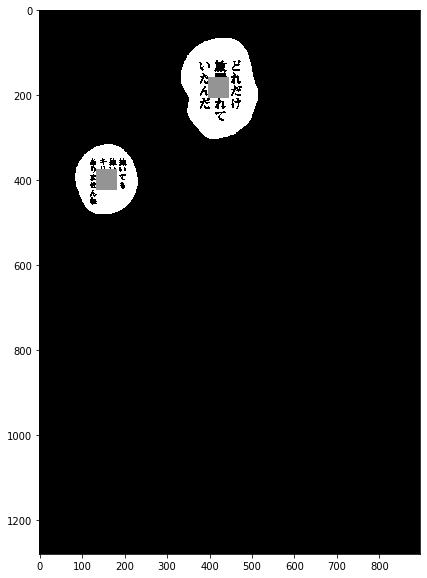

In [37]:
start_time = time.time()

# Debug filtered blobs
dotSize= 25
grey= 126

test= np.zeros([original_image.shape[0], original_image.shape[1], len(filteredBlobLabels)])

for i,b in enumerate(filteredBlobLabels):
    test[:,:,i]= (blobStats[1][:,:] == b)*255
    
    center= blobStats[3][b].astype(np.uint16)
    centerBlock= [center[0]-dotSize, center[0]+dotSize, center[1]-dotSize, center[1]+dotSize]
    
    centerBlock[1]= np.minimum(centerBlock[1], test.shape[1])
    centerBlock[3]= np.minimum(centerBlock[3], test.shape[0])
    centerBlock[0]= np.maximum(centerBlock[0], 0)
    centerBlock[2]= np.maximum(centerBlock[2], 0)
    
    test[centerBlock[2]:centerBlock[3], centerBlock[0]:centerBlock[1], i] = grey
    #get_ax().imshow(test[:,:,i].astype(np.uint8), cmap='Greys_r')
    #print(np.max(test[:,:,i]), np.mean(test[:,:,i]))
    
flat= (flatten(test.astype(np.uint8)))
#flat= flat / np.max(flat) * 255
get_ax().imshow(flat, cmap='Greys_r')

debug_list= [str(x) + ": " + str(blobStats[3][x]) + " - " + str(blobStats[2][x][4]) for x in filteredBlobLabels]
print(f"Selected blobs:\n{chr(10).join(debug_list)}")

png.from_array(np.uint8(flat), mode="L").save(f"C:/Users/Pray/Pictures/5comps.png")

print("--- %s seconds ---" % (time.time() - start_time))

## Final Result

--- 0.3290731906890869 seconds ---


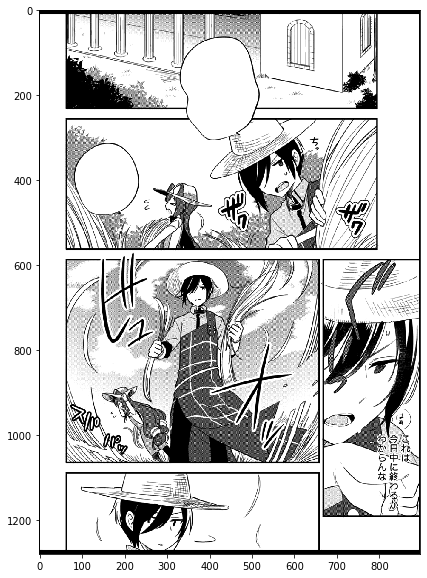

In [38]:
start_time = time.time()

cleaned_image= original_image
for b in filteredBlobLabels:
    comp= blobStats[1][:,:] == b
    comp= comp*255
    disp= np.dstack((comp,comp,comp))
    #get_ax().imshow(disp.astype(np.uint8), cmap='Greys_r')
    
    fill= scipy.ndimage.binary_fill_holes(comp).astype(np.uint8)*255
    
    cleaned_image= np.maximum(fill[:,:,np.newaxis], cleaned_image)

disp_image2= np.concatenate((cleaned_image,cleaned_image,cleaned_image),axis=2)
get_ax().imshow(disp_image2.astype(np.uint8), cmap='Greys_r')

PIL.Image.fromarray(disp_image2.astype(np.uint8)).save(f"C:/Users/Pray/Pictures/6final.png")

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.8301753997802734 seconds ---


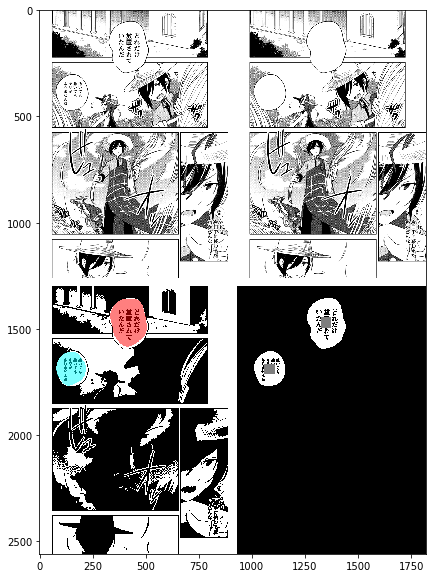

In [39]:
start_time = time.time()

dmask= visualize.display_instances(disp_arr, r['rois'], r['masks'], r['class_ids'], 
                            ['a']*123, r['scores'], hide=True)

# Debug Montage
border= 40
dims= [depad(disp_image,padding).shape[0], depad(disp_image,padding).shape[1], 3]
montage= np.ones([dims[0]*2+border, dims[1]*2+border, 3])*255

montage[0:dims[0], 0:dims[1], :]= depad(disp_image,padding)
montage[dims[0]+border:dims[0]*2+border, 0:dims[1], :]= depad(dmask,padding)#im

montage[0:dims[0], dims[1]+border:dims[1]*2+border, :]= depad(disp_image2,padding)
montage[dims[0]+border:dims[0]*2+border, dims[1]+border:dims[1]*2+border, :]= np.dstack((depad(flat,padding),depad(flat,padding),depad(flat,padding)))

get_ax().imshow(montage.astype(np.uint8))

PIL.Image.fromarray(montage.astype(np.uint8)).save(f"C:/Users/Pray/Pictures/7montage.png")

print("--- %s seconds ---" % (time.time() - start_time))

(1280, 896, 1)
(1260, 890, 1) 255


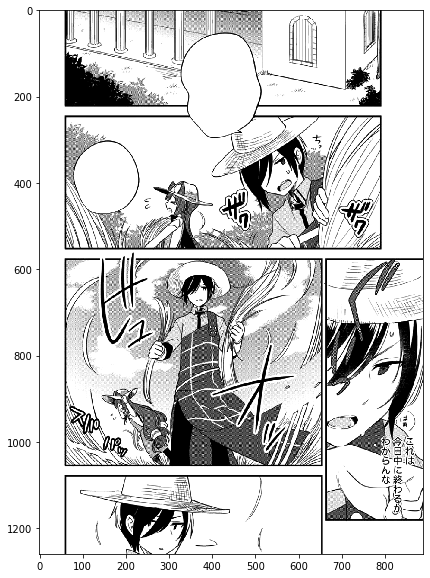

In [41]:
print(original_image.shape)
test= depad(cleaned_image, padding=padding)
print(test.shape, np.max(test))

test=np.concatenate((test,test,test),axis=2)
get_ax().imshow(test,cmap='Greys_r')